In [2]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [3]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ypy-websocket 0.8.2 requires aiofiles<23,>=22.1.0, but you have aiofiles 23.1.0 which is incompatible.


## Binary image classifier

The following notebook is a image classifier created by fine tuning resnet18 model. This is created using Jeremy Howard's FastAI notebook as the base. Link to the original [notebook](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data).

**How it works?**

Here I have generalized the notebook, so that it can classify any two objects. The dataset for the two objects specified will be downloaded from the internet using duckduckgo image search engine. The images thus obtained is used to create the dataset, then resnet18 model is finetuned with the created dataset to classify images from both the classes.

**Disclaimer**

The performance depends on the images downloaded, and it can vary from run-to-run.

## Specify the classes and keywords for variations in searches (User Input)

In [20]:
class_1 = 'motorcycle'
class_2 = 'car'
class_1_variation_keywords = ['side view', 'front view']
class_2_variation_keywords = ['side view', 'front view']

## Download images of Motorcycle and Cars

In [21]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [22]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images(f'{class_1} photos', max_images=1)
urls[0]

Searching for 'motorcycle photos'


'https://thumbs.dreamstime.com/b/race-motorcycle-traveling-forest-road-30290229.jpg'

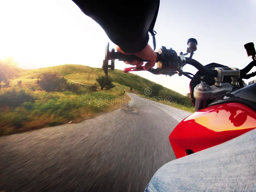

In [23]:
from fastdownload import download_url
dest = f'{class_1}.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'car photos'


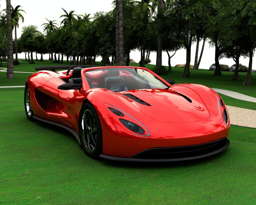

In [24]:
download_url(search_images(f'{class_2} photos', max_images=1)[0], f'{class_2}.jpg', show_progress=False)
Image.open(f'{class_2}.jpg').to_thumb(256,256)

## Creating dataset of Motorcycle and Car images

In [25]:
searches = class_1,class_2
path = Path(f'{class_1}_or_{class_2}')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    if o == class_1:
        download_images(dest, urls=search_images(f'{o} {class_1_variation_keywords[0]} photo'))
        sleep(10)
        download_images(dest, urls=search_images(f'{o} {class_1_variation_keywords[1]} photo'))
    else:
        download_images(dest, urls=search_images(f'{o} {class_2_variation_keywords[0]} photo'))
        sleep(10)
        download_images(dest, urls=search_images(f'{o} {class_2_variation_keywords[1]} photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'motorcycle photo'
Searching for 'motorcycle side view photo'
Searching for 'motorcycle front view photo'
Searching for 'car photo'
Searching for 'car side view photo'
Searching for 'car front view photo'


## Training Model

#### Remove corrupt photos

In [26]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

7

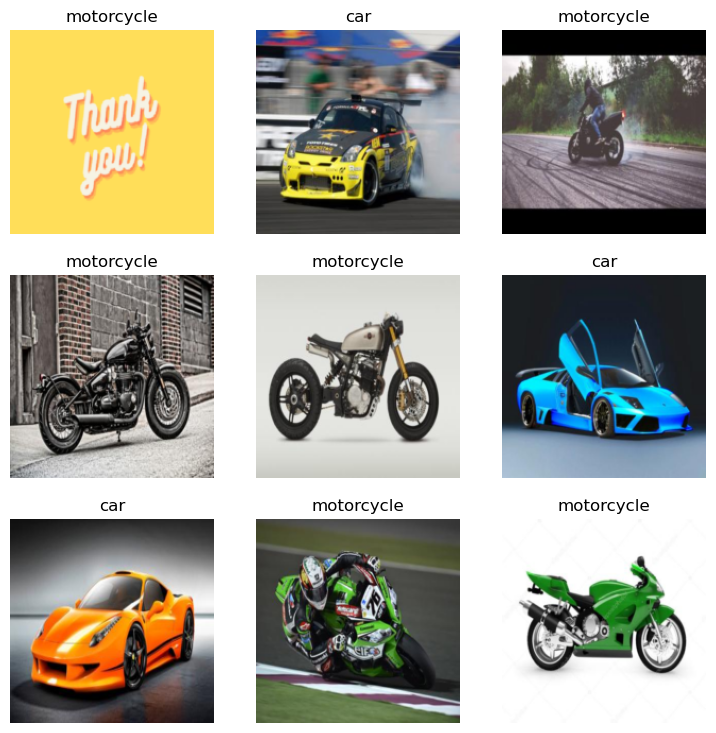

In [27]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=9)

#### Downloading pretrained restnet18 model fine tuning it on the above dataset

In [28]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.801852,0.026129,0.000000,00:17


epoch,train_loss,valid_loss,error_rate,time
0,0.128674,0.025220,0.015152,00:25
1,0.067796,0.006385,0.000000,00:25
2,0.056573,0.002031,0.000000,00:24
3,0.043986,0.002343,0.000000,00:25
4,0.035126,0.002156,0.000000,00:24


### Check how well did the fine tuned model do on our initial image

In [29]:
cat,_,probs = learn.predict(PILImage.create('motorcycle.jpg'))
print(f"This is a: {cat}.")
print(f"Probability it's a motorcycle: {probs[0]:.4f}")

This is a: motorcycle.
Probability it's a motorcycle: 0.0000


In [30]:
cat,_,probs = learn.predict(PILImage.create('car.jpg'))
print(f"This is a: {cat}.")
print(f"Probability it's a car: {probs[0]:.4f}")

This is a: car.
Probability it's a car: 1.0000
